In [1]:
# Load Libraries
import os
import glob
from torchvision.datasets.folder import default_loader
from torchvision.transforms import ToTensor, Compose
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR 
import torch.nn.functional as F
from tqdm import tqdm
import csv
import time
import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [2]:
# Data preprocessing
# Data preprocessing
augment_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel grayscale to 3-channel
    transforms.Resize((224, 224)),                # Resize to fit VGG19 input dimensions
    transforms.ToTensor()
])

root_dir = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/'

def skipping_stride(images_dir, window_size=10, stride=1):
    images = sorted(glob.glob(os.path.join(images_dir, '*.tif')))
    sequences = []
    # if we are predicting LSTM images then should not multiply 
    for start in range(0, len(images), stride * window_size):
        window = images[start: start + stride * window_size:stride]
        sequence = [augment_transforms(default_loader(f)) for f in window]
        sequence_tensor = torch.stack(sequence, dim=0)
        sequences.append(sequence_tensor)
    return sequences

data = []

for subfolder in tqdm(sorted(os.listdir(root_dir)), desc="Processing Subfolders"):
    folder_path = os.path.join(root_dir, subfolder)
    for stride_value in [1,2]:
        sequences = skipping_stride(folder_path, stride=stride_value)
        if sequences:
            data.extend(sequences)


data_tensor = torch.stack(data, dim=0)
print(data_tensor.shape)

# Create the dataset from the tensor
dataset = TensorDataset(data_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Processing Subfolders: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:14<00:00,  2.29it/s]


torch.Size([1020, 10, 3, 224, 224])


torch.Size([1, 10, 3, 224, 224])


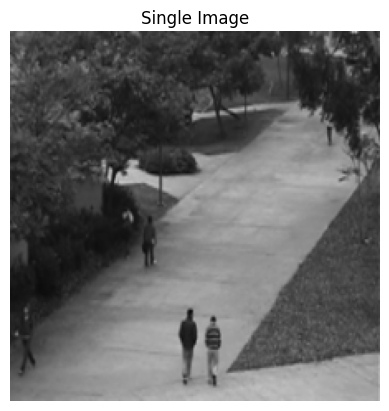

In [3]:
def plot_image_tensor(tensor_image):
    # CxHxW to HxWxC or getting invalid dimensions
    tensor_image = tensor_image.permute(1, 2, 0)  
    plt.imshow(tensor_image.numpy())
    plt.title('Single Image')
    plt.axis('off') 
    plt.show()

# Testing the dataset
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create an iterator from the DataLoader
train_loader_iter = iter(train_loader)

# Fetch the next batch
batch = next(train_loader_iter) 

print(batch[0].shape)

plot_image_tensor(batch[0][0][0])  # Plot the first image from the batch

In [33]:
import torch
import torch.nn as nn
from torchvision.models import vgg19, VGG19_Weights


class ConvLSTMCell(nn.Module):

    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.gates = nn.Conv2d(in_channels=input_channels + hidden_channels,
                               out_channels=4 * hidden_channels,  # For input, forget, cell, and output gates
                               kernel_size=kernel_size,
                               padding=self.padding)

    def forward(self, input_tensor, hidden_state):
        h_cur, c_cur = hidden_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        # print(f"combined shape: {[input_tensor.shape, h_cur.shape]}")
        # print(f"combined shape -->: {combined.shape}")
        gates = self.gates(combined)
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        input_gate = torch.sigmoid(input_gate)
        forget_gate = torch.sigmoid(forget_gate)
        cell_gate = torch.tanh(cell_gate)
        output_gate = torch.sigmoid(output_gate)

        c_next = forget_gate * c_cur + input_gate * cell_gate
        h_next = output_gate * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_channels, height, width, device=self.gates.weight.device),
                torch.zeros(batch_size, self.hidden_channels, height, width, device=self.gates.weight.device))


class ConvLSTM_VGG19(nn.Module):
    """
    ConvLSTM model with VGG19-based architecture
    """

    def __init__(self):
        super(ConvLSTM_VGG19, self).__init__()

        # Load the pre-trained VGG19 model
        vgg19_model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
      
            
        vgg19_features = vgg19_model.features
        
        # using the first 10 layers of VGG19
        self.encoder = nn.Sequential(*list(vgg19_features.children())[:12])
        

        # ConvLSTM layers
        self.convlstm1 = ConvLSTMCell(
            input_channels=256, hidden_channels=64, kernel_size=3)
        self.convlstm2 = ConvLSTMCell(
            input_channels=64, hidden_channels=32, kernel_size=3)
        self.convlstm3 = ConvLSTMCell(
            input_channels=32, hidden_channels=64, kernel_size=3)

        # Spatial Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64,
                               kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=128,
                               kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=3,
                               kernel_size=4, stride=2, padding=2)
        )

    def forward(self, x):
        b, seq_len, _, h, w = x.size()
        #print("******:", x.shape)
        # input to convLSTM will be whatever coming from the encoder 
        # concatenate whatever the initialization of hidden LSTM will be
        
        _, _, vgg_height, vgg_width = self.encoder(x[:, 0]).shape

        h1, c1 = self.convlstm1.init_hidden(b, (vgg_height, vgg_width))
        h2, c2 = self.convlstm2.init_hidden(b, (vgg_height, vgg_width))
        h3, c3 = self.convlstm3.init_hidden(b, (vgg_height, vgg_width))

        output_sequence = []
        for t in range(seq_len):
            xt = self.encoder(x[:, t])
            h1, c1 = self.convlstm1(xt, (h1, c1))
            h2, c2 = self.convlstm2(h1, (h2, c2))
            h3, c3 = self.convlstm3(h2, (h3, c3))
            xt = self.decoder(h3)
            xt = torch.sigmoid(xt)
            output_sequence.append(xt.unsqueeze(1))

        output_sequence = torch.cat(output_sequence, dim=1)
        return output_sequence

# Example usage
model = ConvLSTM_VGG19()
image = torch.randn(1, 10, 3, 224, 224)
output = model(image)
print(output.size())


torch.Size([1, 10, 3, 224, 224])


cuda
train_loader.dataset: 816
val_loader.dataset: 204
Epoch 1/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:26<00:00,  2.04batch/s]


Epoch [1/100] Average Training Loss: 0.0567
Validation Loss after Epoch 1: 0.0211
Model saved at epoch 1
Epoch 2/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [6/100] Average Training Loss: 0.0076
Validation Loss after Epoch 6: 0.0046
Model saved at epoch 6
Epoch 7/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.04batch/s]


Epoch [7/100] Average Training Loss: 0.0069
Validation Loss after Epoch 7: 0.0041
Model saved at epoch 7
Epoch 8/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [8/100] Average Training Loss: 0.0064
Validation Loss after Epoch 8: 0.0039
Model saved at epoch 8
Epoch 9/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [9/100] Average Training Loss: 0.0062
Validation Loss after Epoch 9: 0.0037
Model saved at epoch 9
Epoch 10/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [10/100] Average Training Loss: 0.0071
Validation Loss after Epoch 10: 0.0039
Epoch 11/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:26<00:00,  2.04batch/s]


Epoch [11/100] Average Training Loss: 0.0055
Validation Loss after Epoch 11: 0.0033
Model saved at epoch 11
Epoch 12/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [12/100] Average Training Loss: 0.0051
Validation Loss after Epoch 12: 0.0031
Model saved at epoch 12
Epoch 13/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [13/100] Average Training Loss: 0.0050
Validation Loss after Epoch 13: 0.0030
Model saved at epoch 13
Epoch 14/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [14/100] Average Training Loss: 0.0047
Validation Loss after Epoch 14: 0.0029
Model saved at epoch 14
Epoch 15/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [15/100] Average Training Loss: 0.0045
Validation Loss after Epoch 15: 0.0029
Model saved at epoch 15
Epoch 16/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [16/100] Average Training Loss: 0.0045
Validation Loss after Epoch 16: 0.0035
Epoch 17/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [17/100] Average Training Loss: 0.0046
Validation Loss after Epoch 17: 0.0027
Model saved at epoch 17
Epoch 18/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [18/100] Average Training Loss: 0.0042
Validation Loss after Epoch 18: 0.0026
Model saved at epoch 18
Epoch 19/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [19/100] Average Training Loss: 0.0041
Validation Loss after Epoch 19: 0.0024
Model saved at epoch 19
Epoch 20/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [20/100] Average Training Loss: 0.0060
Validation Loss after Epoch 20: 0.0030
Epoch 21/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.04batch/s]


Epoch [21/100] Average Training Loss: 0.0042
Validation Loss after Epoch 21: 0.0025
Epoch 22/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [22/100] Average Training Loss: 0.0040
Validation Loss after Epoch 22: 0.0024
Model saved at epoch 22
Epoch 23/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [23/100] Average Training Loss: 0.0038
Validation Loss after Epoch 23: 0.0024
Model saved at epoch 23
Epoch 24/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [24/100] Average Training Loss: 0.0037
Validation Loss after Epoch 24: 0.0023
Model saved at epoch 24
Epoch 25/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:26<00:00,  2.04batch/s]


Epoch [25/100] Average Training Loss: 0.0036
Validation Loss after Epoch 25: 0.0023
Model saved at epoch 25
Epoch 26/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.04batch/s]


Epoch [26/100] Average Training Loss: 0.0036
Validation Loss after Epoch 26: 0.0024
Epoch 27/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [27/100] Average Training Loss: 0.0035
Validation Loss after Epoch 27: 0.0022
Model saved at epoch 27
Epoch 28/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [28/100] Average Training Loss: 0.0034
Validation Loss after Epoch 28: 0.0021
Model saved at epoch 28
Epoch 29/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [32/100] Average Training Loss: 0.0031
Validation Loss after Epoch 32: 0.0020
Model saved at epoch 32
Epoch 33/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [33/100] Average Training Loss: 0.0030
Validation Loss after Epoch 33: 0.0020
Model saved at epoch 33
Epoch 34/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [34/100] Average Training Loss: 0.0030
Validation Loss after Epoch 34: 0.0019
Model saved at epoch 34
Epoch 35/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [35/100] Average Training Loss: 0.0029
Validation Loss after Epoch 35: 0.0019
Epoch 36/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:26<00:00,  2.04batch/s]


Epoch [36/100] Average Training Loss: 0.0029
Validation Loss after Epoch 36: 0.0018
Model saved at epoch 36
Epoch 37/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [37/100] Average Training Loss: 0.0028
Validation Loss after Epoch 37: 0.0018
Epoch 38/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [38/100] Average Training Loss: 0.0028
Validation Loss after Epoch 38: 0.0018
Model saved at epoch 38
Epoch 39/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [39/100] Average Training Loss: 0.0027
Validation Loss after Epoch 39: 0.0018
Model saved at epoch 39
Epoch 40/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [40/100] Average Training Loss: 0.0027
Validation Loss after Epoch 40: 0.0017
Model saved at epoch 40
Epoch 41/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [41/100] Average Training Loss: 0.0026
Validation Loss after Epoch 41: 0.0017
Epoch 42/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [42/100] Average Training Loss: 0.0026
Validation Loss after Epoch 42: 0.0017
Epoch 43/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:26<00:00,  2.04batch/s]


Epoch [43/100] Average Training Loss: 0.0026
Validation Loss after Epoch 43: 0.0018
Epoch 44/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [44/100] Average Training Loss: 0.0027
Validation Loss after Epoch 44: 0.0018
Epoch 45/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [45/100] Average Training Loss: 0.0025
Validation Loss after Epoch 45: 0.0016
Model saved at epoch 45
Epoch 46/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [46/100] Average Training Loss: 0.0024
Validation Loss after Epoch 46: 0.0016
Model saved at epoch 46
Epoch 47/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [47/100] Average Training Loss: 0.0024
Validation Loss after Epoch 47: 0.0016
Epoch 48/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [48/100] Average Training Loss: 0.0024
Validation Loss after Epoch 48: 0.0016
Epoch 49/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [49/100] Average Training Loss: 0.0023
Validation Loss after Epoch 49: 0.0016
Epoch 50/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [50/100] Average Training Loss: 0.0023
Validation Loss after Epoch 50: 0.0015
Model saved at epoch 50
Epoch 51/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [51/100] Average Training Loss: 0.0023
Validation Loss after Epoch 51: 0.0015
Model saved at epoch 51
Epoch 52/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [52/100] Average Training Loss: 0.0022
Validation Loss after Epoch 52: 0.0015
Epoch 53/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [53/100] Average Training Loss: 0.0022
Validation Loss after Epoch 53: 0.0015
Epoch 54/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [54/100] Average Training Loss: 0.0022
Validation Loss after Epoch 54: 0.0015
Epoch 55/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [55/100] Average Training Loss: 0.0021
Validation Loss after Epoch 55: 0.0014
Model saved at epoch 55
Epoch 56/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [56/100] Average Training Loss: 0.0021
Validation Loss after Epoch 56: 0.0014
Model saved at epoch 56
Epoch 57/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [57/100] Average Training Loss: 0.0021
Validation Loss after Epoch 57: 0.0014
Epoch 58/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [58/100] Average Training Loss: 0.0020
Validation Loss after Epoch 58: 0.0013
Model saved at epoch 58
Epoch 59/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.04batch/s]


Epoch [59/100] Average Training Loss: 0.0020
Validation Loss after Epoch 59: 0.0014
Epoch 60/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [60/100] Average Training Loss: 0.0020
Validation Loss after Epoch 60: 0.0013
Model saved at epoch 60
Epoch 61/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [61/100] Average Training Loss: 0.0020
Validation Loss after Epoch 61: 0.0012
Model saved at epoch 61
Epoch 62/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [62/100] Average Training Loss: 0.0019
Validation Loss after Epoch 62: 0.0013
Epoch 63/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [63/100] Average Training Loss: 0.0019
Validation Loss after Epoch 63: 0.0013
Epoch 64/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [64/100] Average Training Loss: 0.0019
Validation Loss after Epoch 64: 0.0012
Model saved at epoch 64
Epoch 65/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [68/100] Average Training Loss: 0.0018
Validation Loss after Epoch 68: 0.0012
Epoch 69/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [69/100] Average Training Loss: 0.0018
Validation Loss after Epoch 69: 0.0012
Model saved at epoch 69
Epoch 70/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [70/100] Average Training Loss: 0.0017
Validation Loss after Epoch 70: 0.0012
Epoch 71/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [71/100] Average Training Loss: 0.0017
Validation Loss after Epoch 71: 0.0011
Model saved at epoch 71
Epoch 72/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [72/100] Average Training Loss: 0.0017
Validation Loss after Epoch 72: 0.0012
Epoch 73/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [73/100] Average Training Loss: 0.0017
Validation Loss after Epoch 73: 0.0013
Epoch 74/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [74/100] Average Training Loss: 0.0017
Validation Loss after Epoch 74: 0.0012
Epoch 75/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [75/100] Average Training Loss: 0.0017
Validation Loss after Epoch 75: 0.0012
Epoch 76/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [76/100] Average Training Loss: 0.0016
Validation Loss after Epoch 76: 0.0011
Model saved at epoch 76
Epoch 77/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.04batch/s]


Epoch [77/100] Average Training Loss: 0.0016
Validation Loss after Epoch 77: 0.0012
Epoch 78/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [78/100] Average Training Loss: 0.0016
Validation Loss after Epoch 78: 0.0012
Epoch 79/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [79/100] Average Training Loss: 0.0016
Validation Loss after Epoch 79: 0.0012
Epoch 80/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [83/100] Average Training Loss: 0.0016
Validation Loss after Epoch 83: 0.0011
Epoch 84/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [84/100] Average Training Loss: 0.0015
Validation Loss after Epoch 84: 0.0012
Epoch 85/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [85/100] Average Training Loss: 0.0015
Validation Loss after Epoch 85: 0.0011
Epoch 86/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [86/100] Average Training Loss: 0.0015
Validation Loss after Epoch 86: 0.0012
Epoch 87/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [87/100] Average Training Loss: 0.0015
Validation Loss after Epoch 87: 0.0011
Epoch 88/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [88/100] Average Training Loss: 0.0015
Validation Loss after Epoch 88: 0.0011
Epoch 89/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [89/100] Average Training Loss: 0.0016
Validation Loss after Epoch 89: 0.0010
Model saved at epoch 89
Epoch 90/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.04batch/s]


Epoch [90/100] Average Training Loss: 0.0015
Validation Loss after Epoch 90: 0.0012
Epoch 91/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [91/100] Average Training Loss: 0.0015
Validation Loss after Epoch 91: 0.0013
Epoch 92/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [94/100] Average Training Loss: 0.0014
Validation Loss after Epoch 94: 0.0012
Epoch 95/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [95/100] Average Training Loss: 0.0014
Validation Loss after Epoch 95: 0.0012
Epoch 96/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [96/100] Average Training Loss: 0.0014
Validation Loss after Epoch 96: 0.0012
Epoch 97/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.03batch/s]


Epoch [97/100] Average Training Loss: 0.0014
Validation Loss after Epoch 97: 0.0011
Epoch 98/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [98/100] Average Training Loss: 0.0014
Validation Loss after Epoch 98: 0.0012
Epoch 99/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [99/100] Average Training Loss: 0.0014
Validation Loss after Epoch 99: 0.0011
Epoch 100/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:27<00:00,  2.02batch/s]


Epoch [100/100] Average Training Loss: 0.0014
Validation Loss after Epoch 100: 0.0012


Text(0.5, 0, 'Epochs')

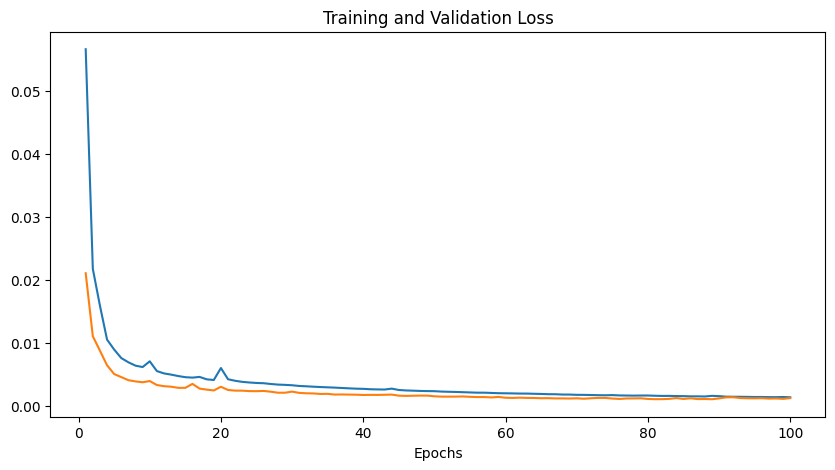

In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 15
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"train_loader.dataset: {len(train_loader.dataset)}")
print(f"val_loader.dataset: {len(val_loader.dataset)}")

model = ConvLSTM_VGG19()  # Assuming ConvLSTM_VGG19 is defined elsewhere
model = nn.DataParallel(model)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, eps=1e-6, weight_decay=1e-5)

# Early stopping parameters
patience = 15
best_val_loss = float('inf')
patience_counter = 0
best_model_path = 'VGG19_ConvLSTM.pth'

# CSV file to store training statistics
csv_file = open('VGG19_ConvLSTM_training_statistics.csv', mode='w', newline='')
csv_writer = csv.writer(csv_file, delimiter=',')
csv_writer.writerow(['Epoch', 'Start Time', 'End Time', 'Duration (s)', 'Training Loss', 'Validation Loss'])

train_losses = []
val_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    total_loss = 0.0
    num_batches = 0

    print(f'Epoch {epoch + 1}/{num_epochs}')
    for (images,) in tqdm(train_loader, unit='batch'):
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    train_losses.append(average_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}] Average Training Loss: {average_loss:.4f}')
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (images,) in val_loader:
            images = images.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, images).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Validation Loss after Epoch {epoch + 1}: {val_loss:.4f}')

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    start_time_str = datetime.datetime.fromtimestamp(epoch_start_time).strftime('%Y-%m-%d %H:%M:%S')
    end_time_str = datetime.datetime.fromtimestamp(epoch_end_time).strftime('%Y-%m-%d %H:%M:%S')
    csv_writer.writerow([epoch + 1, start_time_str, end_time_str, epoch_duration, average_loss, val_loss])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f'Model saved at epoch {epoch + 1}')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch + 1}')
        break

csv_file.close()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')

In [99]:
# Create an instance of the model
model = ConvLSTM_VGG19()
model = nn.DataParallel(model)
# Load the saved model parameters
model.load_state_dict(torch.load('VGG19_ConvLSTM.pth'))
model.to(device)
# Set the model to evaluation mode if you are using it for inference
model.eval()

from PIL import Image
  
files = [f"Test/Test019/{x:03d}.tif" for x in range(100,200)]

files_iter = iter(files)
 

./UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test019/115.tif
torch.Size([1, 1, 3, 224, 224])
Output shape: torch.Size([1, 1, 3, 224, 224])
Mean Squared Error: 0.0033549645


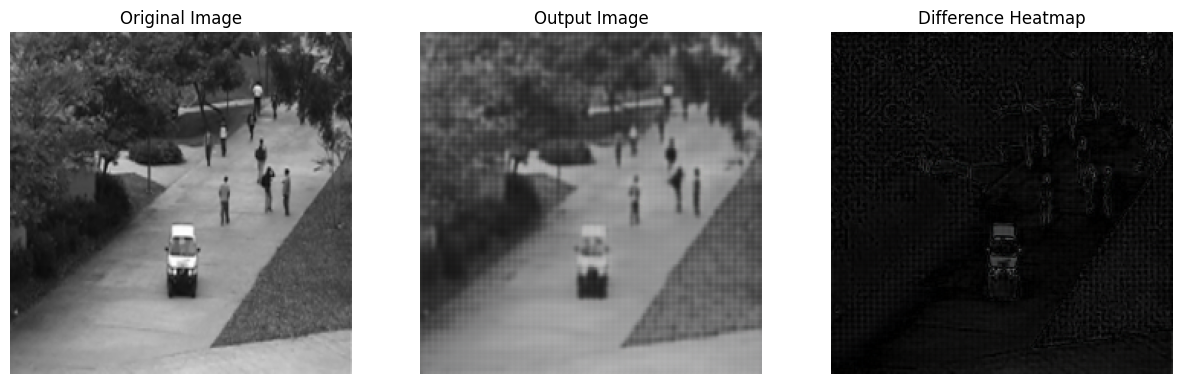

In [115]:

# Load one image for testing
image_path = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/' + next(files_iter)
image = Image.open(image_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform =   transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale
    transforms.Resize((224, 224)),                # Resize if necessary
    transforms.ToTensor()                         # Convert to tensor
])
image = transform(image).to(device)
image = image.unsqueeze(1).unsqueeze(1)  # Add a batch dimension at the front 
image = image.permute(1,2, 0, 3, 4)  # Rearranges to [1, 3, 158, 238, 1]
print(image_path)
print(image.shape)
 
with torch.no_grad():
    output = model(image).to(device)
    print("Output shape:", output.shape)

# Convert to NumPy arrays for visualization
np_image = image.squeeze().cpu().numpy()
np_output = output.squeeze().cpu().numpy()

# If the images have channels as the first dimension, transpose them to (H, W, C)
if np_image.shape[0] in (1, 3):
    np_image = np_image.transpose(1, 2, 0)
if np_output.shape[0] in (1, 3):
    np_output = np_output.transpose(1, 2, 0)




# Calculate the absolute difference
difference = np.abs(np_image - np_output) 

# Calculate the MSE
mse = np.mean((np_image - np_output) ** 2)

print("Mean Squared Error:", mse)

# Create a heatmap to visualize the differences
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np_output, cmap='gray')
plt.title('Output Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(difference, cmap='hot')
plt.title('Difference Heatmap')
plt.axis('off')

plt.show()

